In [105]:
import os
import numpy as np
import pandas as pd
import scipy.ndimage
import scipy.misc

import matplotlib.pyplot as plt

In [117]:
images = []
for filename in sorted(os.listdir('data-1517884138')):
    if 'csv' in filename:
        continue
    images.append(np.load('data-1517884138' + '/' + filename))

labels = pd.read_csv('data-1517884138/labels.csv', index_col=0)
labels.sort_index(inplace=True)

In [97]:
resized = np.stack([scipy.ndimage.interpolation.zoom(arr, 32/200) for arr in images])
images = np.stack(arr for arr in images)

In [98]:
images.shape
resized.shape

(9, 32, 32, 32)

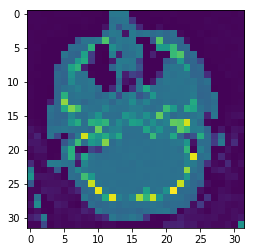

In [99]:
%matplotlib inline
plt.imshow(resized[8][31])

In [100]:
def normalize(image, lower_bound=None, upper_bound=None):
    if lower_bound is None:
        lower_bound = image.min()
    if upper_bound is None:
        upper_bound = image.max()
        
    image[image > upper_bound] = upper_bound
    image[image < lower_bound] = lower_bound
    
    return (image - image.mean()) / image.std()

normalized = zero_center(normalize(resized))

In [101]:
# TODO: Create a model that runs
# TODO: Start tuning the model
import torch
from torch.autograd import Variable
from torch import nn

In [163]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(-1)
        return x
    
model = nn.Sequential(nn.Conv3d(1, 10, 5),
                      nn.ReLU(),
                      nn.Conv3d(10, 20, 5),
                      nn.ReLU(),
                      Flatten(),
                      nn.Linear(276480, 1000),
                      nn.Linear(1000, 2),
                      nn.Softmax(dim=0))
model.train()

Sequential(
  (0): Conv3d (1, 10, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (1): ReLU()
  (2): Conv3d (10, 20, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (3): ReLU()
  (4): Flatten(
  )
  (5): Linear(in_features=276480, out_features=1000)
  (6): Linear(in_features=1000, out_features=2)
  (7): Softmax()
)

In [164]:
# TODO: 
x = Variable(torch.from_numpy(normalized[8]).float())
x = x.unsqueeze(0).unsqueeze(0)
print('In shape:', x.shape)
y = model(x)
print('Out shape:', y.shape)
print(y)

In shape: torch.Size([1, 1, 32, 32, 32])
Out shape: torch.Size([2])
Variable containing:
 0.5140
 0.4860
[torch.FloatTensor of size 2]



In [165]:
from torch.optim import SGD
from torch.nn import BCELoss

optimizer = SGD(model.parameters(), lr=0.01)
criterion = BCELoss()

In [167]:
def train():
    for image3d, label in zip(normalized, labels['label'].values):
        image3d = Variable(torch.Tensor(image3d).unsqueeze(0).unsqueeze(0))
        true_label = Variable(torch.Tensor([int(label == 0), int(label == 1)]))
        optimizer.zero_grad()
        pred_label = model(image3d)
        loss = criterion(pred_label, true_label)
        loss.backward()
        optimizer.step()

In [168]:
for _ in range(10):
    train()

In [180]:
model(Variable(torch.Tensor(normalized[8]).unsqueeze(0).unsqueeze(0)))

Variable containing:
 0.9999
 0.0001
[torch.FloatTensor of size 2]